This post aims to introduce how to use fastai v2 to implement entity embedding for categorical variables in tabular data. Entity embedding is a powerful technique that can sometimes boost the performance of various machine learning methods and reveal the intrinsic properties of categorical variables. See this [paper](https://arxiv.org/abs/1604.06737) and this [post](https://www.fast.ai/2018/04/29/categorical-embeddings/) for more details.

In [1]:
#| include: false
%%capture
!pip3 install fastai --upgrade

In [2]:
#| include: false
def check_fastai_version():
  import fastai
  assert fastai.__version__ >= '2.0'

In [3]:
#| include: false
check_fastai_version()

In [4]:
import seaborn as sns
from fastai.tabular.all import *

In [5]:
#| include: false
set_seed(36)

## Get Data

In [6]:
#| include: false
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

In [7]:
#| include: false
download_data(HOUSING_URL, fname='housing.tgz')
file_extract('housing.tgz')

We will use the California housing dataset for this post. We want to develop a model to predict the median_house_value based on other variables in the dataset. The following code shows the first 5 rows of the dataset.

In [8]:
df = pd.read_csv('housing.csv')
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


## Preprocess Data

We rely on various functionalities provided by fastai to preprocess the data. We will not discuss them in detail here. For more information, please check this [tutorial](https://docs.fast.ai/tutorial.tabular). One important note is that when dealing with categorical variables, instead of using one-hot encoding, we map each category into a distinct integer.

In [9]:
#| include: false
doc(cont_cat_split)

cont_cat_split(df, max_card=20, dep_var=None)
Helper function that returns column names of cont and cat variables from given `df`.

To get a prettier result with hyperlinks to source code and documentation, install nbdev: pip install nbdev


In [10]:
cont, cat = cont_cat_split(df, dep_var = 'median_house_value')

In [11]:
splits = RandomSplitter(valid_pct=0.2)(range_of(df))

In [12]:
to = TabularPandas(df, procs=[Categorify, FillMissing,Normalize],
                   cat_names = cat,
                   cont_names = cont,
                   y_names='median_house_value',
                   splits=splits)

In [13]:
dls = to.dataloaders(bs=64)

In [14]:
#| include: false
dls.show_batch()

,ocean_proximity,total_bedrooms_na,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,NEAR OCEAN,False,-118.360001,33.790001,34.000000,5166.000080,703.999998,2071.000018,668.000003,8.3609,500001.0
1,<1H OCEAN,False,-118.389999,34.189999,41.000000,1999.999969,485.000002,1439.000000,461.000001,3.0491,192000.0
2,NEAR OCEAN,False,-122.489998,37.740002,52.000001,2442.000001,448.999997,1187.999996,436.000002,4.3909,317700.0
3,<1H OCEAN,False,-118.250000,33.930000,42.000000,818.999971,232.999988,899.000006,228.000002,1.1346,85400.0
4,<1H OCEAN,False,-117.940002,34.080002,35.000000,2392.999992,417.000002,1336.000000,418.000000,4.8700,187700.0
5,INLAND,False,-121.300003,37.919998,28.000000,3307.999980,765.999992,3201.000057,719.999996,1.7694,73900.0
6,<1H OCEAN,False,-118.339996,33.979999,40.000000,2108.000009,526.000000,1921.999997,543.999999,3.1630,137800.0
7,NEAR OCEAN,False,-117.019997,32.740002,12.000000,3300.999974,962.999995,1999.999999,878.999991,1.8594,119200.0
8,INLAND,False,-122.949997,40.669998,17.000000,1498.000017,331.000000,574.000003,241.999992,2.0268,94200.0
9,<1H OCEAN,False,-121.989998,37.270000,21.000000,1214.000022,192.000001,499.999997,184.999993,7.5980,347800.0


## Train Model

We will train a deep learning model to predict the median housing value and thus get the trained embedding for categorical variables. Again, see this [tutorial](https://docs.fast.ai/tutorial.tabular) for details about the meaning of the codes here.

In [15]:
learn = tabular_learner(dls, metrics=rmse)

In [16]:
early_stop_cb = EarlyStoppingCallback(patience=2)

In [17]:
#collapse-output
learn.fit_one_cycle(10, cbs=early_stop_cb)

epoch,train_loss,valid_loss,_rmse,time
0,55994937344.000000,56636186624.000000,237983.578125,00:04
1,56567816192.000000,56058937344.000000,236767.671875,00:04
2,52564221952.000000,52214001664.000000,228503.843750,00:03
3,45972250624.000000,46276349952.000000,215119.375000,00:03
4,37385846784.000000,37008117760.000000,192374.937500,00:03
5,31154010112.000000,30351321088.000000,174216.312500,00:03
6,24364992512.000000,23757260800.000000,154133.906250,00:03
7,22229555200.000000,21549965312.000000,146799.031250,00:03
8,20496922624.000000,21110308864.000000,145293.875000,00:03
9,20571899904.000000,20511488000.000000,143218.312500,00:03


## Get Embedding

We will retrieve the trained embedding matrix from the model.

In [18]:
embs = [param for param in learn.model.embeds.parameters()]

The list has two elements and each element represents an embedding matrix for a categorical variable.

In [19]:
len(embs)

2

To check what each element corresponds to, we can use the `cat_names` attributes from `TabularPandas`. The list indicates that the first element in `embs` is the embedding matrix for the variable ocean_proximity.

In [20]:
to.cat_names

(#2) ['ocean_proximity','total_bedrooms_na']

Let's see this matrix. Note that we convert it from a tensor array to a numpy array to make the operation later easier.

In [21]:
ocean_emb = embs[0].detach().numpy()
ocean_emb

array([[ 0.00074246,  0.01322438, -0.00539126,  0.00066858],
       [-0.01550745, -0.02467075,  0.01956671, -0.01148492],
       [ 0.24266721,  0.35117084, -0.35875005,  0.36369336],
       [-0.05629548, -0.06088502,  0.08677642, -0.10355063],
       [-0.01115109, -0.02015582,  0.01277605, -0.00476734],
       [-0.01796132, -0.02396758,  0.02242134, -0.0143294 ]],
      dtype=float32)

Each row in the matrix above corresponds to one category in the categorical variable. The categories for ocean_proximity are the following.

In [22]:
cat = to.procs.categorify
ocean_cat = cat['ocean_proximity']
ocean_cat

['#na#', '<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN']

We can use the `o2i` attribute to see how each category is mapped into an integer. The integer corresponds to the row in the embedding matrix.

In [23]:
ocean_cat.o2i

defaultdict(int,
            {'#na#': 0,
             '<1H OCEAN': 1,
             'INLAND': 2,
             'ISLAND': 3,
             'NEAR BAY': 4,
             'NEAR OCEAN': 5})

For example, the embedding for 'NEAR BAY' is:

In [24]:
ocean_emb[4]

array([-0.01115109, -0.02015582,  0.01277605, -0.00476734], dtype=float32)

Let's create a dictionary to map each category to its corresponding embedding.

In [25]:
ocean_emb_map = {ocean_cat[i]:ocean_emb[i] for i in range(len(ocean_cat))}

In [26]:
#| include: false
ocean_emb_map

{'#na#': array([ 0.00074246,  0.01322438, -0.00539126,  0.00066858], dtype=float32),
 '<1H OCEAN': array([-0.01550745, -0.02467075,  0.01956671, -0.01148492], dtype=float32),
 'INLAND': array([ 0.24266721,  0.35117084, -0.35875005,  0.36369336], dtype=float32),
 'ISLAND': array([-0.05629548, -0.06088502,  0.08677642, -0.10355063], dtype=float32),
 'NEAR BAY': array([-0.01115109, -0.02015582,  0.01277605, -0.00476734], dtype=float32),
 'NEAR OCEAN': array([-0.01796132, -0.02396758,  0.02242134, -0.0143294 ], dtype=float32)}

## Apply Embedding

This section shows how we can apply the embedding to the original dataset; that is, change the category variable to numeric vectors.

In [27]:
emb_dim = ocean_emb.shape[1]

In [28]:
col_name = [f'ocean_emb_{i}' for i in range(1,emb_dim+1)]
df_emb = pd.DataFrame(df['ocean_proximity'].map(ocean_emb_map).to_list(), columns=col_name)
df_emb.head()

,ocean_emb_1,ocean_emb_2,ocean_emb_3,ocean_emb_4
0,-0.011151,-0.020156,0.012776,-0.004767
1,-0.011151,-0.020156,0.012776,-0.004767
2,-0.011151,-0.020156,0.012776,-0.004767
3,-0.011151,-0.020156,0.012776,-0.004767
4,-0.011151,-0.020156,0.012776,-0.004767


In [29]:
df_new = pd.concat([df, df_emb],axis=1)

In [30]:
#| include: false
df_new.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,ocean_emb_1,ocean_emb_2,ocean_emb_3,ocean_emb_4
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,-0.011151,-0.020156,0.012776,-0.004767
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,-0.011151,-0.020156,0.012776,-0.004767
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,-0.011151,-0.020156,0.012776,-0.004767
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,-0.011151,-0.020156,0.012776,-0.004767
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,-0.011151,-0.020156,0.012776,-0.004767


## Visualize Embedding

Another way to explore the embedding matrix is to visualize it and see what it learns. We will use principle component analysis(PCA) to visualize the embedding.

In [31]:
from sklearn import decomposition
pca = decomposition.PCA(n_components=2)
pca_result = pca.fit_transform(ocean_emb)

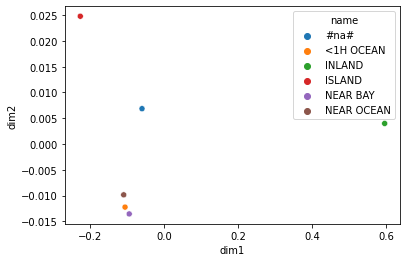

In [32]:
df_visualize = pd.DataFrame({'name':ocean_cat, 'dim1':pca_result[:,0], 'dim2':
                             pca_result[:,1]})
sns.scatterplot(data=df_visualize, x='dim1', y='dim2', hue='name');

If we compare this visualization to the map of these houses above, we will find that the embedding matrix does provide some useful insights. In particular, we see that the relative location of the category INLAND does correspond to the inland area in the map. The code to make the following map comes from this [notebook](https://github.com/ageron/handson-ml2/blob/master/02_end_to_end_machine_learning_project.ipynb).

In [33]:
#| include: false
PROJECT_ROOT_DIR = "."
images_path = os.path.join(PROJECT_ROOT_DIR, "images", "end_to_end_project")
os.makedirs(images_path, exist_ok=True)
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
filename = "california.png"
print("Downloading", filename)
url = DOWNLOAD_ROOT + "images/end_to_end_project/" + filename
urllib.request.urlretrieve(url, os.path.join(images_path, filename))

('./images/end_to_end_project/california.png',
 <http.client.HTTPMessage at 0x7fdcd28383c8>)

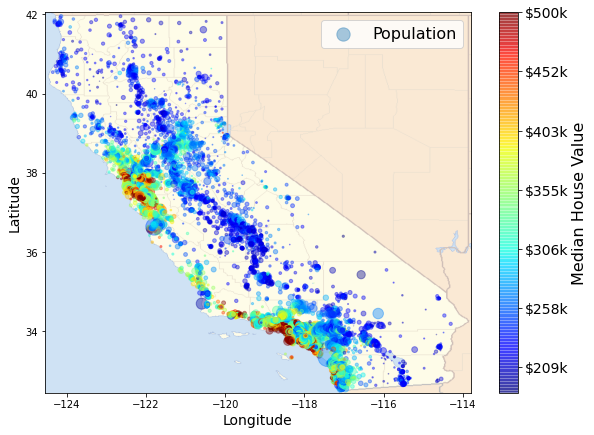

In [34]:
#| echo: false
import matplotlib.image as mpimg
california_img=mpimg.imread(os.path.join(images_path, filename))
ax = df.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7),
                       s=df['population']/100, label="Population",
                       c="median_house_value", cmap=plt.get_cmap("jet"),
                       colorbar=False, alpha=0.4,
                      )
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = df["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar(ticks=tick_values/prices.max())
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Median House Value', fontsize=16)

plt.legend(fontsize=16)
plt.show()

## Ending Note

This is the end of this post. You can see the full code by clicking to the **View on Github** or **Open in Colab** tab at the top this post.